In [1]:
import uproot
import h5py
import numpy as np
import os
import awkward as awk

In [2]:
# pick random file
dir_root_lightjet = '/eos/atlas/atlascerngroupdisk/perf-flavtag/calib/negtag/Rel24_GN2/mc20_Run2/Ntuples/PeriodE/ZJets_MG'

## di-electron

In [3]:
subdir_ee = 'user.ltoffoli.mc20_13TeV.506193.MGPy8EG_3jets_HT2bias_BFilter.deriv.DAOD_PHYS.e8382_s3681_r13145_p5631.toffoGN2_v1_output.root'

In [4]:
fname_ee = os.listdir(os.path.join(dir_root_lightjet,subdir_ee))[3]

In [5]:
tree = uproot.open(os.path.join(dir_root_lightjet,subdir_ee,fname_ee)+':nominal')

In [6]:
samples_ee = tree.arrays(['el_e','mu_e','el_charge','mu_charge','el_pt','mu_pt', 'el_phi','mu_phi',\
                      'el_eta', 'mu_eta', 'jet_e'])

In [7]:
samples_ee

<Array [{el_e: [2.04e+05, ... 5.28e+05]}] type='1594528 * {"el_e": var * float32...'>

In [8]:
samples_ee[2].el_phi

<Array [1.25, 0.2] type='2 * float32'>

In [9]:
# sum over both electrons
ee_px = awk.sum(samples_ee.el_pt * np.cos(samples_ee.el_phi),axis=1)
ee_py = awk.sum(samples_ee.el_pt * np.sin(samples_ee.el_phi),axis=1)
ee_pz = awk.sum(samples_ee.el_pt * np.sinh(samples_ee.el_eta),axis=1)

In [10]:
ee_px

<Array [1.74e+05, 4.15e+05, ... -1.03e+05] type='1594528 * float32'>

In [11]:
ee_pt3d = ee_px**2 + ee_py**2 + ee_pz**2
ee_e3d = awk.sum(np.sqrt((samples_ee.el_pt*np.cosh(samples_ee.el_eta))**2 + (511e-3)**2),axis=1)

In [12]:
ee_e3d

<Array [2.55e+05, 5.51e+05, ... 2.2e+05] type='1594528 * float32'>

In [13]:
ee_e3d**2 - ee_pt3d

<Array [7.54e+09, 8.05e+09, ... 7.95e+09] type='1594528 * float32'>

In [14]:
samples_ee['ee_m'] = np.sqrt(ee_e3d**2 - ee_pt3d)

In [15]:
ee_m = samples_ee['ee_m']

In [16]:
type(ee_m)

awkward.highlevel.Array

## di-muon

In [17]:
subdir_mumu = 'user.ltoffoli.mc20_13TeV.506196.MGPy8EG_3jets_HT2bias_BFilter.deriv.DAOD_PHYS.e8382_s3681_r13145_p5631.toffoGN2_v1_output.root'
fname_mumu = os.listdir(os.path.join(dir_root_lightjet,subdir_mumu))[2]

In [18]:
tree = uproot.open(os.path.join(dir_root_lightjet,subdir_mumu,fname_mumu)+':nominal')

In [19]:
samples_mumu = tree.arrays(['el_e','mu_e','el_charge','mu_charge','el_pt','mu_pt', 'el_phi','mu_phi',\
                      'el_eta', 'mu_eta', 'jet_e'])

In [20]:
samples_mumu

<Array [{el_e: [], mu_e: [, ... 2.35e+04]}] type='2943751 * {"el_e": var * float...'>

In [21]:
samples_mumu[2].mu_phi

<Array [2.77, -0.297] type='2 * float32'>

In [22]:
# sum over both muons
mu_px = awk.sum(samples_mumu.mu_pt * np.cos(samples_mumu.mu_phi),axis=1)
mu_py = awk.sum(samples_mumu.mu_pt * np.sin(samples_mumu.mu_phi),axis=1)
mu_pz = awk.sum(samples_mumu.mu_pt * np.sinh(samples_mumu.mu_eta),axis=1)

In [23]:
mu_pt3d = mu_px**2 + mu_py**2 + mu_pz**2
mu_e3d = awk.sum(np.sqrt((samples_mumu.mu_pt*np.cosh(samples_mumu.mu_eta))**2 + (105.7)**2),axis=1)

In [24]:
samples_mumu['mumu_m'] = np.sqrt(mu_e3d**2 - mu_pt3d)

In [25]:
mumu_m = samples_mumu['mumu_m']

In [26]:
import matplotlib.pyplot as plt
from matplotlib import colors
import os
import numpy as np
import mplhep as hep

In [27]:
palette = ['#3E96A1', '#EC4E20', '#FF9505', '#713E5A', '#D62828', '#5F0F40']

In [28]:
def get_bg_idx(sample_names, bg_name):

    if bg_name is not None:
        return [i for (i,s) in enumerate(sample_names) if bg_name in s][0]
    else:
        return -1

In [29]:
def plot_feature_for_n_samples(data, sample_names, bins=100, xlabel='x', ylabel='fraction events', title=None, clip_outlier=False, normed=True, \
    ylogscale=True, xlim=None, plot_name='feature_hist', fig_dir=None, fig_format='.pdf', fig_size=(7,7), bg_name=None, histtype_bg='stepfilled', \
    show_plt=False, legend_outside=True):
    '''
    plots single feature distribution for multiple samples as 1D histogram
    :param data: list of J ndarrays of each N feature values
    :param bg_name: if not None, one sample will be treated as background and plotted in histtype_bg style
    '''

    # import ipdb; ipdb.set_trace()

    # if one sample is to be treated as background sample
    bg_idx = get_bg_idx(sample_names, bg_name)

    plt.style.use(hep.style.CMS)

    fig = plt.figure(figsize=(7,5))
    if ylogscale:
        plt.yscale('log')

    for i, (dat, col) in enumerate(zip(data, palette)):
        if i == bg_idx:
            plt.hist(dat, bins=bins, density=normed, alpha=0.5, histtype=histtype_bg, label=sample_names[i], color=col)
        else:
            plt.hist(dat, bins=bins, density=normed, alpha=1.0, histtype='step', label=sample_names[i], color=col)

    if xlim:
        plt.xlim(xlim)
    plt.grid()
    plt.gca().tick_params(axis='both', which='major', labelsize=14)
    plt.ylabel(ylabel, fontsize=16)
    plt.xlabel(xlabel, fontsize=16)
    if legend_outside:
        handles, labels = plt.gca().get_legend_handles_labels()
        lgd = fig.legend(handles, labels, bbox_to_anchor=(0.5,-0.1), loc="lower center", ncol=len(data), labelspacing=0.8, fontsize=16)
        bbox_extra_artists = (lgd,)
    else:
        plt.legend(loc='best', fontsize=15)
        bbox_extra_artists = None
    plt.tight_layout()
    if show_plt:
        plt.show()
    if fig_dir:
        print('writing figure to ' + os.path.join(fig_dir, plot_name + fig_format))
        fig.savefig(os.path.join(fig_dir, plot_name + fig_format), bbox_extra_artists=bbox_extra_artists, bbox_inches='tight')
    plt.close(fig)


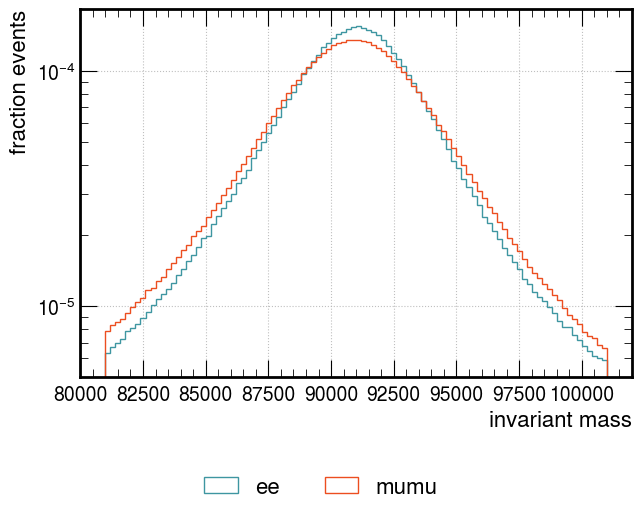

In [30]:
data = [ee_m, mumu_m]
sample_names = ['ee','mumu']
plot_feature_for_n_samples(data,sample_names,xlabel='invariant mass',show_plt=True)

In [31]:
sum((ee_m > 80e3) & (ee_m < 100e3))

1584543

In [33]:
mask_mumu = (awk.num(samples_mumu['mu_e']) == 2) & (awk.sum(samples_mumu['mu_charge'],axis=1) == 0)

In [34]:
sum(mask_mumu)

2943751

In [35]:
from typing import Tuple

def calc_dilepton_px_py_pz(pt:awk.highlevel.Array, eta:awk.highlevel.Array, phi:awk.highlevel.Array) -> Tuple[awk.highlevel.Array]:

	# compute x,y,z momenta of each lepton and sum -> px,py,pz of dilepton system
	px = awk.sum(pt * np.cos(phi),axis=1)
	py = awk.sum(pt * np.sin(phi),axis=1)
	pz = awk.sum(pt * np.sinh(eta),axis=1)

	return px, py, pz


def calc_invariant_mass(pt:awk.highlevel.Array, eta:awk.highlevel.Array, phi:awk.highlevel.Array, part_m:float) -> awk.highlevel.Array:

	px, py, pz = calc_dilepton_px_py_pz(pt, eta, phi)

	moment2 = px**2 + py**2 + pz**2
	energy = awk.sum(np.sqrt((pt*np.cosh(eta))**2 + part_m**2),axis=1)

	return np.sqrt(energy**2 - moment2)
	

def calc_dilepton_pt(pt:awk.highlevel.Array, eta:awk.highlevel.Array, phi:awk.highlevel.Array) -> float:

	px, py, pz = calc_dilepton_px_py_pz(pt, eta, phi)

	return np.sqrt(px**2 + py**2)


In [36]:
# z mass window
z_m_min, z_m_max = 80e3, 100e3
# particle masses
ele_m, mu_m = 511e-3, 105.7

In [37]:
feature_names = ['el_e','mu_e','el_charge','mu_charge','el_pt','mu_pt', 'el_phi','mu_phi',\
                      'el_eta', 'mu_eta', 'jet_e']

In [38]:
tree_ee = uproot.open(os.path.join(dir_root_lightjet,subdir_ee,fname_ee)+':nominal')

In [39]:
samples_ee = tree_ee.arrays(feature_names)

In [40]:
tree_mumu = uproot.open(os.path.join(dir_root_lightjet,subdir_mumu,fname_mumu)+':nominal')

In [41]:
samples_mumu = tree_mumu.arrays(feature_names)

In [43]:
samples = awk.concatenate([samples_ee,samples_mumu])

In [44]:
len(samples_ee)

1594528

In [45]:
len(samples_mumu)

2943751

In [46]:
len(samples)

4538279

In [47]:
# compute invariant mass of electrons
samples['ee_m'] = calc_invariant_mass(samples.el_pt, samples.el_eta, samples.el_phi, part_m=ele_m)
samples_ee['ee_m'] = calc_invariant_mass(samples_ee.el_pt, samples_ee.el_eta, samples_ee.el_phi, part_m=ele_m)
samples_mumu['ee_m'] = calc_invariant_mass(samples_mumu.el_pt, samples_mumu.el_eta, samples_mumu.el_phi, part_m=ele_m)
# compute invariant mass of muons
samples['mumu_m'] = calc_invariant_mass(samples.mu_pt, samples.mu_eta, samples.mu_phi, part_m=mu_m)
samples_ee['mumu_m'] = calc_invariant_mass(samples_ee.mu_pt, samples_ee.mu_eta, samples_ee.mu_phi, part_m=mu_m)
samples_mumu['mumu_m'] = calc_invariant_mass(samples_mumu.mu_pt, samples_mumu.mu_eta, samples_mumu.mu_phi, part_m=mu_m)

In [48]:
len(samples)

4538279

In [49]:
len(samples_ee)

1594528

In [50]:
# invariant mass of electrons 80-100 GeV
mask_ee_m = (samples['ee_m'] > z_m_min) & (samples['ee_m'] < z_m_max)

In [51]:
sum(mask_ee_m)

1584543

In [52]:
# invariant mass of muons 80-100 GeV
mask_mumu_m = (samples['mumu_m'] > z_m_min) & (samples['mumu_m'] < z_m_max)

In [53]:
sum(mask_mumu_m)

2922544

In [54]:
# exactly two electrons of opposite charge
mask_ee = (awk.num(samples['el_e']) == 2) & (awk.sum(samples['el_charge'],axis=1) == 0) 

In [55]:
sum(mask_ee)

1594528

In [56]:
mask_ee

<Array [True, True, True, ... False, False] type='4538279 * bool'>

In [57]:
# exactly two muons of opposite charge
mask_mumu = (awk.num(samples['mu_e']) == 2) & (awk.sum(samples['mu_charge'],axis=1) == 0)

In [58]:
sum(mask_mumu)

2943751

In [59]:
# exclude events with four leptons
mask_4l = mask_ee & mask_mumu

In [60]:
sum(mask_4l)

0

In [61]:
~mask_4l

<Array [True, True, True, ... True, True, True] type='4538279 * bool'>

In [62]:
mask_ee & (~mask_4l)

<Array [True, True, True, ... False, False] type='4538279 * bool'>

In [63]:
mask_ee

<Array [True, True, True, ... False, False] type='4538279 * bool'>

In [64]:
mask_ee = mask_ee & ~mask_4l
mask_mumu = mask_mumu & ~mask_4l

In [65]:
sum(mask_ee)

1594528

In [66]:
sum(mask_mumu)

2943751

In [67]:
mask_ee_pt = calc_dilepton_pt(samples.el_pt, samples.el_eta, samples.el_phi) > 50e3

In [68]:
mask_mumu_pt = calc_dilepton_pt(samples.mu_pt, samples.mu_eta, samples.mu_phi) > 50e3

In [69]:
mask_ee_pt

<Array [True, True, True, ... False, False] type='4538279 * bool'>

In [70]:
z_pt_min = 50e3

In [71]:
# electrons in Z invariant mass window and transverse momentum > 50GeV
mask_ee = mask_ee & mask_ee_m & mask_ee_pt

In [72]:
# muons in Z invariant mass window
mask_mumu = mask_mumu & mask_mumu_m & mask_mumu_pt

In [73]:
sum(mask_ee) + sum(mask_mumu)

2818923

In [74]:
mask = mask_ee | mask_mumu

In [75]:
sum(mask)

2818923

In [76]:
mask_test = mask_ee[:5]

In [77]:
mask_test

<Array [True, True, True, True, True] type='5 * bool'>

In [78]:
ee_pt = calc_dilepton_pt(samples.el_pt, samples.el_eta, samples.el_phi)
mumu_pt = calc_dilepton_pt(samples.mu_pt, samples.mu_eta, samples.mu_phi)

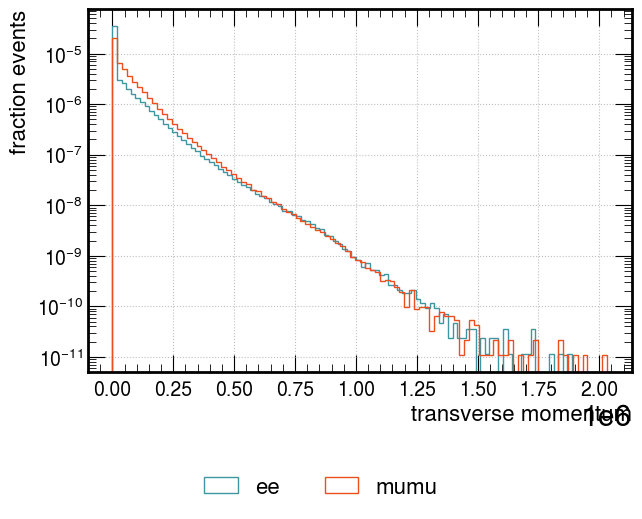

In [79]:
data = [ee_pt, mumu_pt]
sample_names = ['ee','mumu']
plot_feature_for_n_samples(data,sample_names,xlabel='transverse momentum',show_plt=True)

In [80]:
max(ee_pt)

1888126.875

In [81]:
mask_test = mask_test & [False, True, True, False, True]

In [82]:
mask_test

<Array [False, True, True, False, True] type='5 * bool'>

In [83]:
mask_inv = ~mask_test

In [84]:
mask_inv

<Array [True, False, False, True, False] type='5 * bool'>

In [85]:
mask_inv & [True, True, True, True, True]

<Array [True, False, False, True, False] type='5 * bool'>

In [86]:
~mask_inv & [True, True, True, True, True]

<Array [False, True, True, False, True] type='5 * bool'>

In [88]:
import sys
sys.path.append('/eos/home-k/kiwoznia/dev/phys_global')

In [96]:
import physkiplot.src.plotting as heplt

In [99]:
import importlib
importlib.reload(heplt)

<module 'physkiplot.src.plotting' from '/eos/home-k/kiwoznia/dev/phys_global/physkiplot/src/plotting.py'>

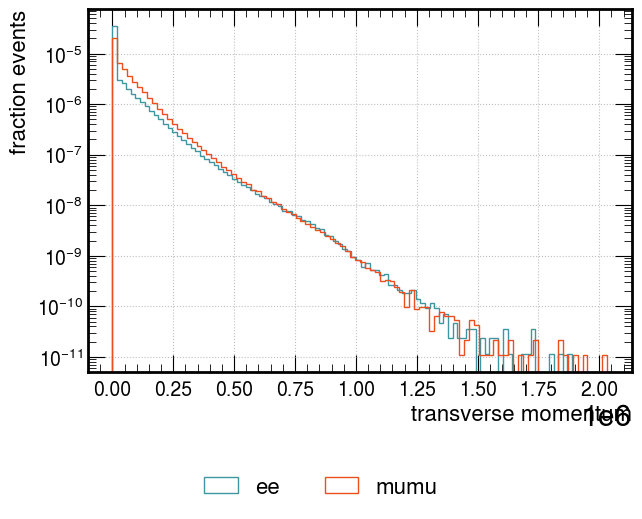

In [100]:
heplt.plot_feature_for_n_samples(data,sample_names,xlabel='transverse momentum',show_plt=True)